In [8]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential 
from keras.layers import Dense, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling2D, Flatten, Dense, RepeatVector 

In [9]:
# Đọc dữ liệu từ tệp CSV
data = pd.read_csv('vcb.csv')

In [10]:
# Xử lý dữ liệu
prices = data['Price']

In [11]:
# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices.values.reshape(-1, 1))

In [12]:
scaled_prices

array([[0.08754242],
       [0.08647225],
       [0.091809  ],
       ...,
       [0.67895011],
       [0.68880691],
       [0.65782841]])

In [13]:
#RATIO 91

In [14]:
# Chia dữ liệu thành tập train test

train_size = int(len(scaled_prices) * 0.9)
test_size = int(len(scaled_prices) * 0.1)

train_data = scaled_prices[:train_size]
test_data = scaled_prices[train_size:train_size+test_size]

In [15]:
test_data

array([[0.82680203],
       [0.81131278],
       [0.80708844],
       [0.80427222],
       [0.8127209 ],
       [0.79582354],
       [0.81131278],
       [0.83102637],
       [0.82398581],
       [0.82257769],
       [0.83665883],
       [0.88031035],
       [0.89439148],
       [0.86622921],
       [0.90847262],
       [0.91551319],
       [0.92255375],
       [0.94367546],
       [0.94508357],
       [0.95775659],
       [0.9788783 ],
       [0.93241055],
       [0.90706451],
       [0.90847262],
       [0.91410507],
       [0.90706451],
       [0.90847262],
       [0.90847262],
       [0.92396187],
       [0.93522678],
       [0.90847262],
       [0.90847262],
       [0.90847262],
       [0.93663489],
       [0.91832941],
       [0.9788783 ],
       [0.94649169],
       [0.95071603],
       [0.96479716],
       [0.97747018],
       [0.9788783 ],
       [0.97606207],
       [0.9690215 ],
       [1.        ],
       [0.9788783 ],
       [0.9788783 ],
       [0.74751116],
       [0.791

In [16]:
# Chia dữ liệu thành các mẫu chuỗi thời gian
def create_time_series(data, time_steps):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)


In [17]:
time_steps = 30  # Số ngày quan sát trước để dự đoán ngày tiếp theo
X_train, y_train = create_time_series(train_data, time_steps)
X_test, y_test = create_time_series(test_data, time_steps)

In [18]:
X_train.shape

(1309, 30, 1)

In [19]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [20]:
# 8. Define GRU Model

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, 1)))
model.add(Conv1D(filters=64, kernel_size=3, activation='softmax'))
model.add(GRU(64, return_sequences = False))
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Biên dịch mô hình
model.compile(optimizer='adam', loss='mean_squared_error')

# Huấn luyện mô hình
model.fit(X_train, y_train, epochs=100, batch_size=64)

# Đánh giá mô hình trên tập kiểm tra
loss = model.evaluate(X_test, y_test)
print('Loss trên tập kiểm tra:', loss)

Epoch 1/100

21/21 [==============================] - 2s 8ms/step - loss: 0.0931
Epoch 2/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0398
Epoch 3/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 4/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0122
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0012
Epoch 7/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 8/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0010
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0011
Epoch 10/100
21/21 [==============================] - 0s 7ms/step - loss: 0.0010
Epoch 11/100
21/21 [==============================] - 0s 8ms/step - loss: 9.7313e-04
Epoch 12/100
21/21 [==============================] - 0s 8ms/step - loss: 9.6468e-04
Epoch 13/100
21/21 [=======

In [22]:
data.index


RangeIndex(start=0, stop=1488, step=1)

In [23]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

# Tạo biến train, test
train = prices[:train_size]
test = prices[train_size:train_size+test_size]

y_test_pred = model.predict(X_test)
y_test_pred = scaler.inverse_transform(y_test_pred)

n_past = 1
n_days_for_prediction= 30

#create an array of 30 integers starting from last index
predict_period_dates = np.array(range(len(data) + 1,len(data) + 31)).reshape(-1, 1)

print(predict_period_dates)

#Make prediction
prediction1 = model.predict(X_test[-n_days_for_prediction:])

prediction_copies1 = np.repeat(prediction1, prices.shape[0], axis=-1)
predicted_prices = scaler.inverse_transform(prediction_copies1)[:,0]
print(predicted_prices)

4/4 [==============================] - 0s 2ms/step
[[1489]
 [1490]
 [1491]
 [1492]
 [1493]
 [1494]
 [1495]
 [1496]
 [1497]
 [1498]
 [1499]
 [1500]
 [1501]
 [1502]
 [1503]
 [1504]
 [1505]
 [1506]
 [1507]
 [1508]
 [1509]
 [1510]
 [1511]
 [1512]
 [1513]
 [1514]
 [1515]
 [1516]
 [1517]
 [1518]]
1/1 [==============================] - 0s 15ms/step
[89604.54  89758.35  90128.79  89379.19  90070.48  89163.18  87054.06
 86355.43  86981.24  88384.19  88785.16  86651.086 86633.805 87645.37
 87668.73  86392.32  86634.55  86824.39  86657.76  85988.766 85541.805
 85795.984 86745.14  86360.08  86504.71  86186.516 85847.42  85147.6
 84994.625 84606.12 ]


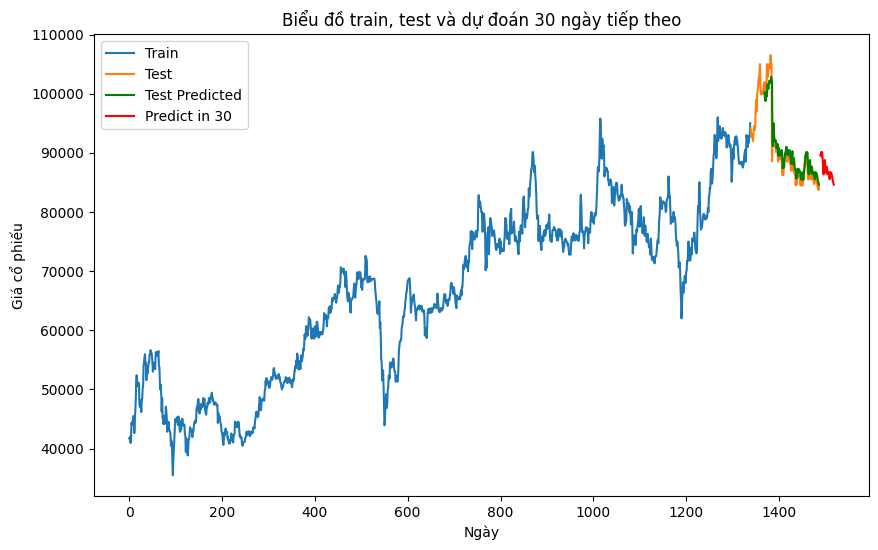

In [24]:
# Tạo biểu đồ train, test và dự đoán 30 ngày tiếp theo
plt.figure(figsize=(10, 6))
plt.plot(train, label='Train')
plt.plot(range(train_size, train_size + len(test)), test, label='Test')

plt.plot(range(train_size + 30,train_size + test_size), y_test_pred, 'g', label='Test Predicted')

plt.plot(predict_period_dates, predicted_prices, 'r', label='Predict in 30')

plt.xlabel('Ngày')
plt.ylabel('Giá cổ phiếu')
plt.title('Biểu đồ train, test và dự đoán 30 ngày tiếp theo')
plt.legend()
plt.show()

In [25]:
y_test_pred

array([[100214.06 ],
       [ 99056.414],
       [ 98755.07 ],
       [ 99075.97 ],
       [100216.31 ],
       [ 99597.08 ],
       [101543.484],
       [101196.22 ],
       [100798.23 ],
       [101477.734],
       [102192.56 ],
       [102173.8  ],
       [102046.43 ],
       [101818.984],
       [102835.43 ],
       [102461.734],
       [102085.586],
       [ 91491.84 ],
       [ 91128.32 ],
       [ 95030.125],
       [ 93695.59 ],
       [ 92431.81 ],
       [ 92193.39 ],
       [ 91900.17 ],
       [ 92111.06 ],
       [ 91456.02 ],
       [ 90751.87 ],
       [ 91351.836],
       [ 91506.164],
       [ 90912.766],
       [ 89467.49 ],
       [ 90793.26 ],
       [ 90270.1  ],
       [ 89531.24 ],
       [ 89887.664],
       [ 90276.89 ],
       [ 90232.24 ],
       [ 90463.2  ],
       [ 89442.88 ],
       [ 87392.04 ],
       [ 87721.26 ],
       [ 87457.61 ],
       [ 87654.89 ],
       [ 88988.26 ],
       [ 89852.586],
       [ 89796.78 ],
       [ 90612.22 ],
       [ 9102

In [26]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, mean_squared_log_error

# Dự đoán giá trong quá trình testing
y_test_predicted = model.predict(X_test)

# Đưa các dự đoán về lại tỷ lệ ban đầu
y_test_predicted = scaler.inverse_transform(y_test_predicted)

y_test1 = scaler.inverse_transform(y_test)


# Tính MAE cho testing
mae_test = mean_absolute_error(y_test1, y_test_predicted)

# Tính MAPE cho testing
mape_test = mean_absolute_percentage_error(y_test1, y_test_predicted)

# Tính RMSE cho testing
rmse_test = mean_squared_error(y_test1, y_test_predicted, squared=False)

# Tính MSLE cho testing
msle_test = mean_squared_log_error(y_test1, y_test_predicted, squared=False)




4/4 [==============================] - 0s 3ms/step


In [27]:
y_test1

array([[100000.],
       [100000.],
       [100000.],
       [102000.],
       [100700.],
       [105000.],
       [102700.],
       [103000.],
       [104000.],
       [104900.],
       [105000.],
       [104800.],
       [104300.],
       [106500.],
       [105000.],
       [105000.],
       [ 88569.],
       [ 91700.],
       [ 93400.],
       [ 92700.],
       [ 93000.],
       [ 91600.],
       [ 91200.],
       [ 91500.],
       [ 90600.],
       [ 90100.],
       [ 90800.],
       [ 90700.],
       [ 90200.],
       [ 88500.],
       [ 90400.],
       [ 89000.],
       [ 88900.],
       [ 89200.],
       [ 89400.],
       [ 89500.],
       [ 89800.],
       [ 88400.],
       [ 86300.],
       [ 87000.],
       [ 86200.],
       [ 87000.],
       [ 88400.],
       [ 89100.],
       [ 89100.],
       [ 90100.],
       [ 90200.],
       [ 89500.],
       [ 89500.],
       [ 88500.],
       [ 89900.],
       [ 89100.],
       [ 89100.],
       [ 89800.],
       [ 88800.],
       [ 8

In [28]:
mape_test *= 100


print('---------TEST----------')
print("MAPE:", round(mape_test,3))
print("MAE:", round(mae_test,3))
print("RMSE:", round(rmse_test,3))
print("MSLE:", round(msle_test,3))
print('-------------------')


---------TEST----------
MAPE: 1.467
MAE: 1334.665
RMSE: 2007.575
MSLE: 0.021
-------------------
